In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from itertools import combinations
from scipy.spatial.distance import cityblock, euclidean

from SupertypeTools import heatmap, SSE

## Processing binding affinity prediction data from NetMHCpan

In [36]:
# split combinded data
in_df = pd.read_csv("../BA_pred/C0401_sorted.csv")
gp = in_df.groupby('MHC')
for x in gp.groups:
    out_df = gp.get_group(x)
    out_df.to_csv(f"../BA_pred/{x}.csv", index=False)

In [47]:
# extract columns from each allele, then combine
alleles = ['A01_01','A26_01','A26_02','A26_03','A30_02','A30_03','A30_04','A32_01','A30_01','A29_02',
'A02_01','A02_02','A02_03','A02_04','A02_05','A02_06','A02_07','A02_14','A02_17','A68_02','A69_01',
'A03_01','A11_01','A31_01','A33_01','A33_03','A66_01','A68_01','A74_01','A23_01','A24_02','B07_02',
'B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01',
'B55_01','B55_02','B56_01','B67_01','B78_01','B08_01','B08_02','B14_02','B15_03','B15_09','B15_10',
'B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02',
'B39_09','B48_01','B73_01','B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01',
'B15_16','B15_17','B57_01','B57_02','B58_01','B58_02','B15_01','B15_02','B15_12','B15_13','B46_01',
'B52_01','C01_02','C03_02','C07_02','C08_01','C08_02','C12_02','C14_02','C16_01','C16_04','C02_02',
'C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01',
'C18_01']

binder = []
affinity = []
top10 = []
for allele in alleles:
    in_df = pd.read_csv(f"../BA_pred/{allele}.csv")
    # binder, affinity < 500 nM
    binder_col = in_df['Aff(nM)'].values <= 500
    binder_col = binder_col.astype(int).tolist()
    binder.append(binder_col)
    # affinity
    aff_col = in_df['Aff(nM)'].values.tolist()
    affinity.append(aff_col)
    # top 10%
    top_col = in_df['%Rank_BA'].values <= 10
    top_col = top_col.astype(int).tolist()
    top10.append(top_col)

out_df1 = pd.DataFrame(binder).transpose()
out_df1.set_axis(alleles, axis=1, inplace=True)
out_df1.to_csv("../BA_pred/binder.csv", index=False)

out_df1 = pd.DataFrame(affinity).transpose()
out_df1.set_axis(alleles, axis=1, inplace=True)
out_df1.to_csv("../BA_pred/affinity.csv", index=False)

out_df1 = pd.DataFrame(top10).transpose()
out_df1.set_axis(alleles, axis=1, inplace=True)
out_df1.to_csv("../BA_pred/top10.csv", index=False)

## Heatmap of prediction data

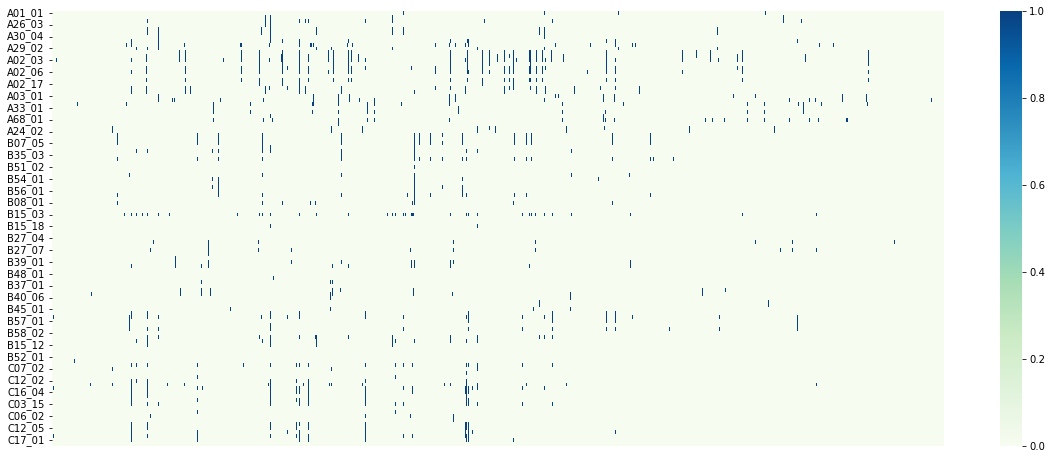

In [71]:
# binder
in_df = pd.read_csv("../BA_pred/binder.csv")

plt.figure(figsize=(20,8))
g = sn.heatmap(in_df.transpose(), xticklabels=False, cmap='GnBu')
# g.axes.tick_params(axis='both', labelsize=6)
plt.show()

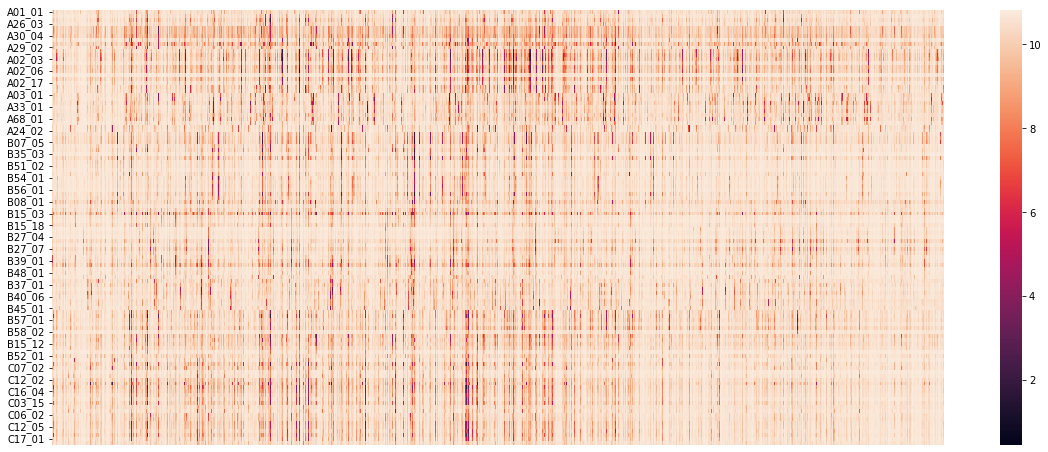

In [66]:
# affinity
in_df = pd.read_csv("../BA_pred/affinity.csv")

plt.figure(figsize=(20,8))
g = sn.heatmap(np.log(in_df.transpose()), xticklabels=False)
plt.show()

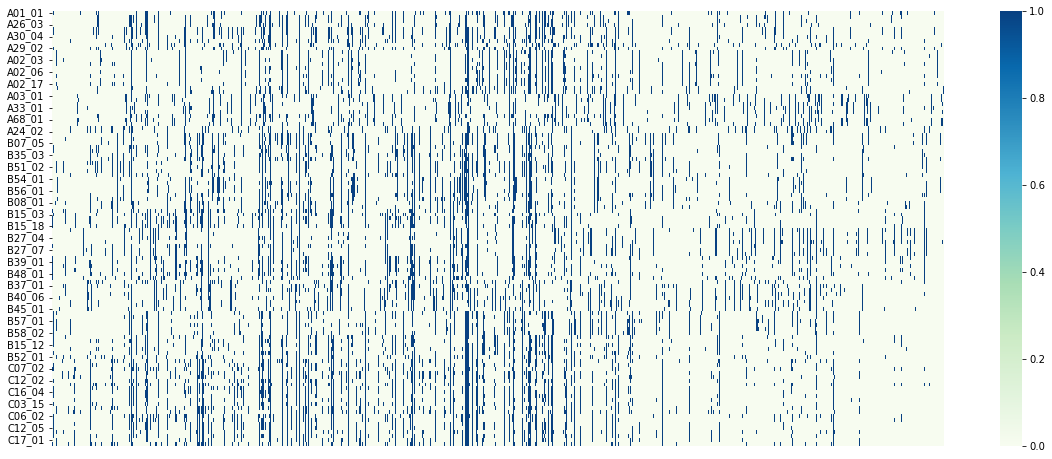

In [68]:
# top 10 percent
in_df = pd.read_csv("../BA_pred/top10.csv")

plt.figure(figsize=(20,8))
g = sn.heatmap(in_df.transpose(), xticklabels=False, cmap='GnBu')
plt.show()

## Distance metrices

In [4]:
class BA_dist():

    def __init__(self):
        self.in_df = None
        self.alleles = None
        self.AlleleComb_wo = None

    def read_csv(self, inCSV):
        self.in_df = pd.read_csv(inCSV)
        self.alleles = self.in_df.columns.values
        self.AlleleComb_wo = combinations(self.alleles, 2)
        return

    def aff_calculate(self):
        self.in_df = np.log(self.in_df)
        DistMat = pd.DataFrame(np.zeros((len(self.alleles), len(self.alleles))), index=self.alleles, columns=self.alleles)
        for comb in self.AlleleComb_wo:
            # dist = np.linalg.norm(self.in_df[comb[0]] - self.in_df[comb[1]], ord = 2)
            dist = euclidean(self.in_df[comb[0]], self.in_df[comb[1]])
            DistMat.loc[comb[1],comb[0]] = dist
        return DistMat

    def bind_calculate(self):
        DistMat = pd.DataFrame(np.zeros((len(self.alleles), len(self.alleles))), index=self.alleles, columns=self.alleles)
        for comb in self.AlleleComb_wo:
            # dist = np.linalg.norm(self.in_df[comb[0]] - self.in_df[comb[1]], ord = 1)
            dist = cityblock(self.in_df[comb[0]], self.in_df[comb[1]])
            DistMat.loc[comb[1],comb[0]] = dist/len(self.alleles)
        return DistMat


    def top_calculate(self):
        DistMat = pd.DataFrame(np.zeros((len(self.alleles), len(self.alleles))), index=self.alleles, columns=self.alleles)
        for comb in self.AlleleComb_wo:
            # dist = np.linalg.norm(self.in_df[comb[0]] - self.in_df[comb[1]], ord = 1)
            dist = cityblock(self.in_df[comb[0]], self.in_df[comb[1]])
            DistMat.loc[comb[1],comb[0]] = dist/10000
        return DistMat

    def aff_matrix(self, affCSV):
        self.read_csv(affCSV)
        Mat = self.aff_calculate()
        return Mat.round(2)

    def bind_matrix(self, bindCSV):
        self.read_csv(bindCSV)
        Mat = self.bind_calculate()
        return Mat

    def top_matrix(self, topCSV):
        self.read_csv(topCSV)
        Mat = self.top_calculate()
        return Mat


### heatmaps for different metrices

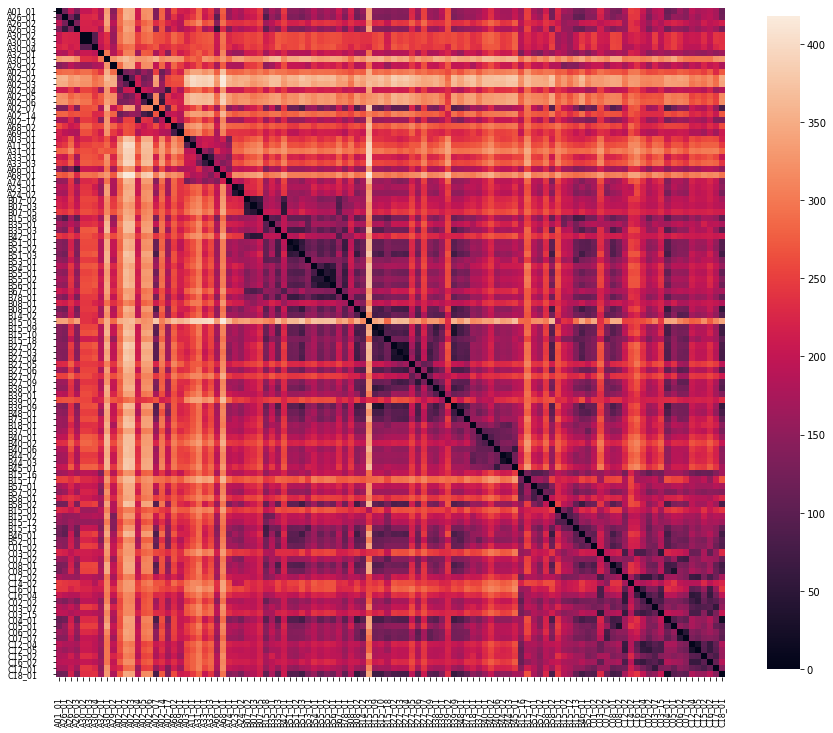

In [11]:
aff_Mat = BA_dist().aff_matrix("../BA_pred/affinity.csv")
heatmap(aff_Mat, size=(15,15))

# aff_Mat = aff_Mat.add(aff_Mat.T, fill_value=0)
aff_Mat.to_csv("../BA_pred/affinity_matrix.csv")

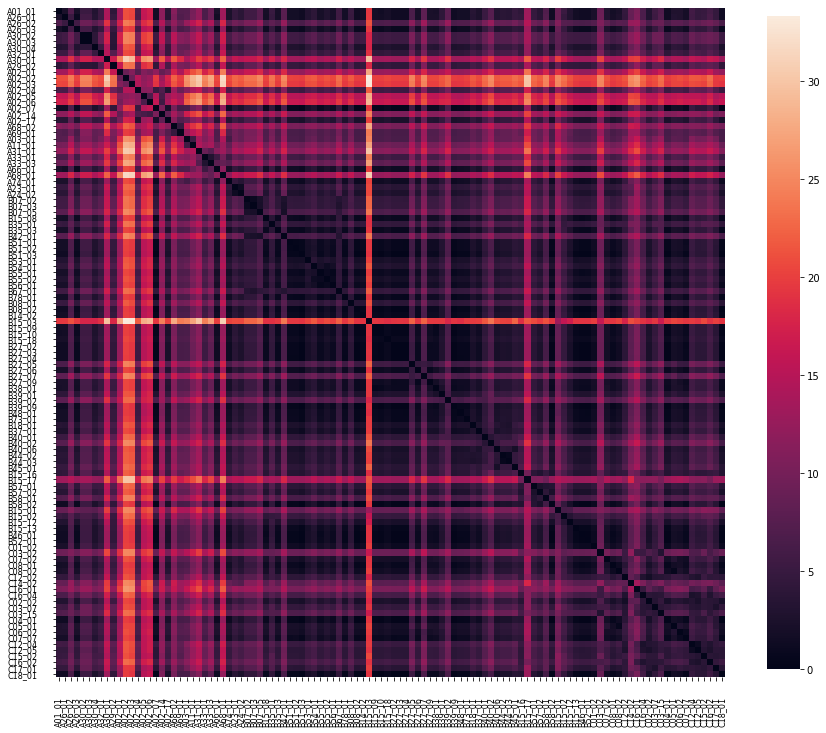

In [12]:
bind_Mat = BA_dist().bind_matrix("../BA_pred/binder.csv")
heatmap(bind_Mat, size=(15,15))

# bind_Mat = bind_Mat.add(bind_Mat.T, fill_value=0)
bind_Mat.to_csv("../BA_pred/binder_matrix.csv")

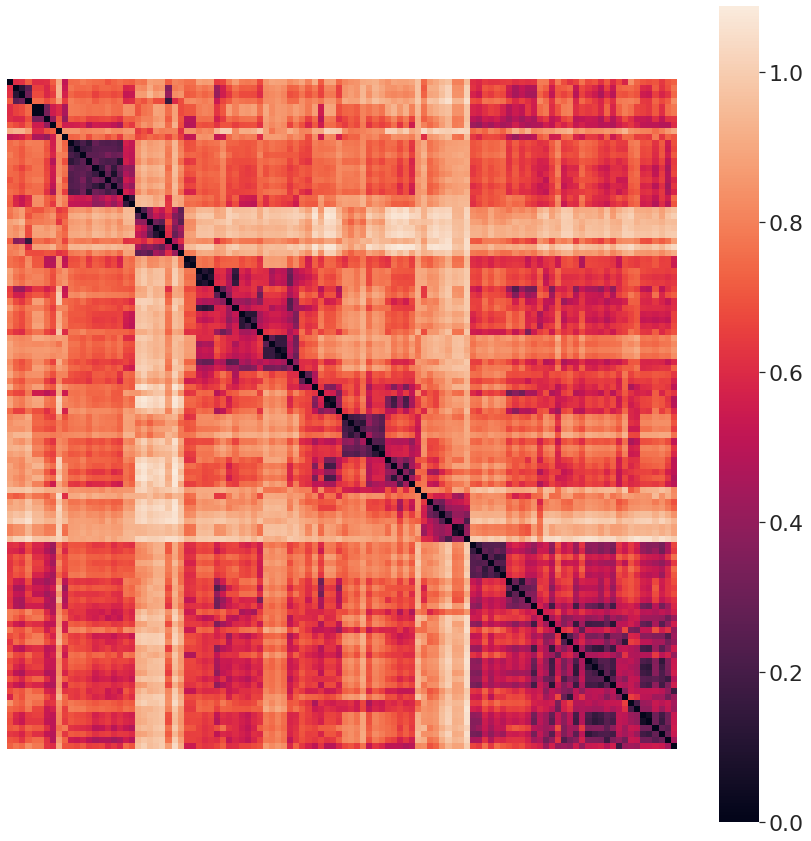

In [5]:
top_Mat = BA_dist().top_matrix("../BA_pred/top10.csv")
heatmap(top_Mat, size=(15,15))

# top_Mat = top_Mat.add(top_Mat.T, fill_value=0)
top_Mat.to_csv("../BA_pred/top10_matrix.csv")

## SSE for multiple methods

In [14]:
# Sidney
A_order = [
    ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01'],
    ['A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01'],
    ['A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01'],
    ['A23_01', 'A24_02']
    ]

B_order = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01'],
    ['B08_01','B08_02'],
    ['B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01'],
    ['B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01'],
    ['B15_16','B15_17','B57_01','B57_02','B58_01','B58_02'],
    ['B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
    ]

mat = pd.read_csv("../BA_pred/top10_matrix.csv", index_col=0)
print(SSE(mat, A_order))
print(SSE(mat, B_order))

5091.036363636364
14936.072727272725


In [16]:
# Doytchinova
A_order = [
    ['A01_01','A29_02','A30_01','A30_02','A30_03','A30_04','A32_01','A03_01','A11_01','A31_01','A33_01','A33_03','A66_01','A68_01','A74_01'],
    ['A26_01','A26_02','A26_03','A02_01','A02_02','A02_03','A02_04','A02_05','A02_06','A02_07','A02_14','A02_17','A68_02','A69_01'],
    ['A23_01','A24_02']
]

B_order = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01','B08_01','B14_02','B15_09','B15_10','B15_18','B39_01','B39_09','B73_01','B18_01','B15_02'],
    ['B51_01','B51_02','B51_03','B53_01','B08_02','B27_02','B38_01','B44_02','B44_03','B57_01','B57_02','B58_01','B58_02','B52_01'],
    ['B15_03','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B39_02','B48_01','B37_01','B40_01','B40_02','B40_06','B45_01','B15_16','B15_17','B15_01','B15_12','B15_13','B46_01']
]

C_order = [
    ['C01_02','C03_02','C07_02','C08_01','C08_02','C12_02','C14_02','C16_01','C16_04'],
    ['C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
]

print(SSE(mat, A_order))
print(SSE(mat, B_order))
print(SSE(mat, C_order))

9840.300000000003
30368.809090909093
4091.3272727272724
